## Parameter exploration 
### This notbook explores the nutrient and PH levels of the water sheds that have statistically sigificant temperature change in the past five years 
##### Going to work on connecting US Census API to explore what is happening in these regions
##### Also need to modularize the code more, but running into issues with pandas dataframe and objects

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.mode.chained_assignment = None
import folium
import random
from mpl_toolkits import mplot3d 





### Import the data set

In [2]:
#Import data set
#If you want to work with entire data set uncomment the line below else use the random sampling
water_quality_final = pd.read_csv('Water_FINAL.csv', low_memory= False)

#n = 2708716 #number of records in file water_final.csv
#s = 10000 #desired sample size
#filename = "Water_FINAL.csv"
#skip = sorted(random.sample(range(1,n+1),n-s))

#water_quality_final = pd.read_csv(filename, skiprows=skip, low_memory=False)


### Drop the unecessary columns from the data set as these columns are mostly filled with nans

In [3]:
water_quality_final.drop(columns = {"Unnamed: 0", "Unnamed: 0.1", "Agency", "BiasPC", "CloudCover", "Comments"}, inplace = True )
list_of_columns = list(water_quality_final.columns)



### Convert the date formate to pandas datetime format for time series modeling


### Replace the different tier levels to all be standardized. 

In [4]:
water_quality_final['Date'] = pd.to_datetime(water_quality_final.Date)
water_quality_final["TierLevel"].unique()
water_quality_final["TierLevel"]= water_quality_final["TierLevel"].replace({"T3": 3, "p2": 2,"p1": 1, "3.0": 3, "2.0": 2,"1.0": 1})

water_quality_final["TierLevel"] = water_quality_final["TierLevel"].astype(int)

In [5]:
water_collection_dates = water_quality_final[water_quality_final["Unit"] == "DEG C"  ]
water_collection_dates = water_collection_dates["Date"].where(water_quality_final["TierLevel"] == 3)
water_temp = water_quality_final[water_quality_final["Unit"] == "DEG C"]
water_temp = water_temp["MeasureValue"].where(water_quality_final["TierLevel"] == 3)

In [6]:
### Now lets find yearly averages and box plot them. 


In [7]:
### Now lets find yearly averages and box plot them. 
water_quality_final['Date'] = pd.to_datetime(water_quality_final.Date)



#### Get the water shed
####  `HUC12_`, `HUCNAME_`, `Parameter`, `HUC12_`, `Unit`, `Latitude`, `Longitude`

##### Watersheds
    HUC 12 – Lick Run Bald Eagle Creek
    HUC 10 - Bald Eagle Creek
    HUC 8 - Bald Eagle
    HUC 6 - West Branch Susquehanna
    HUC 4 – Susquehanna

In [9]:
## Get the key names of the creeks that we are looking for
## Turn them in to lower case strings just in case capitalization is an issue
## Finally, filter based on key words
a= list(water_quality_final["HUCNAME_"].unique())
for i in range(0,len(a)-1): a[i] = a[i].lower()
susqu_creeks  = list(filter(lambda lam_s: "susquehanna" in lam_s, a)) 
bald_eagle_creeks = list(filter(lambda lam_be: "bald eagle" in lam_be, a))
lick_run_creeks = list(filter(lambda lam_lc: "lick run" in lam_lc, a)) 
    

In [10]:
## convert to lower case instead of capitalization errors 
water_quality_final["HUCNAME_"] = water_quality_final["HUCNAME_"].str.lower()

## Now we want to filter the data frame to find the lat, long of these points as well as water temp and nutrient composition

point_1_df = water_quality_final[water_quality_final['HUCNAME_'].str.contains("susquehanna|bald eagle|codorus|juniata", na=False) ]

In [11]:
## Plotting methods
print("Data collection date range of point_1 ", point_1_df["Date"].min(), point_1_df["Date"].max())
#point_1_parameters = point_1_df["Parameter"].unique()



Data collection date range of point_1  2005-07-11 00:00:00 2020-05-24 00:00:00


In [12]:
def makeDistPlot(data, label, units):
    distplot = sns.distplot(data.MeasureValue)
   
    plt.xlabel('Year')
    plt.ylabel(units)
    plt.title('Distribution plot of' + label +  '\n' + units)
    plt.show()
    return distplot
def makeScatterPlot(data, label, units, ymw):
   
    if(ymw == 'y'):
        plt.title("Scatter plot of mean year  of  " + label + '\n'+ units)
        plt.xlabel('Year')
        yearplot = sns.scatterplot(x = "Year", y = data["MeasureValue"].mean(), data = data)
    if(ymw == 'm'):
        plt.title("Scatter plot of monthly level of  " + label + '\n'+ units)
        plt.xlabel('Month')
        yearplot = sns.scatterplot(x = "Month", y = data["MeasureValue"], data = data)
    if(ymw == 'w'):
        #NEEd the titles to change
        plt.title("Scatter plot of weekly level of  " + label + '\n'+ units)
        plt.xlabel('Week')
        yearplot = sns.scatterplot(x = "WeekOfYear", y = data["MeasureValue"], data = data)
    
    plt.ylabel(units)
    plt.show()
        
    return yearplot
def make3Dfig(data, label):
# Creating figure 
    fig = plt.figure(figsize = (10, 10)) 
    ax = plt.axes(projection ="3d") 

    # Creating plot 
    ax.scatter3D(data.Year, data.WeekOfYear, data.MeasureValue, color = "green"); 
    ax.set_xlabel("Year")
    ax.set_ylabel("Week of Year")
    ax.set_zlabel("Nutrient level")
    plt.title(label) 

    # show plot 
    plt.show() 
    return 



### Lets plot the PH over time

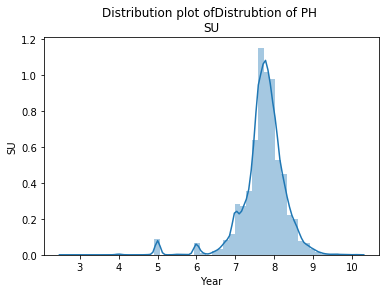

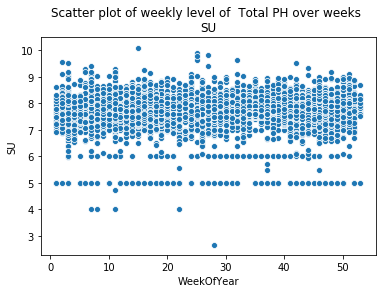

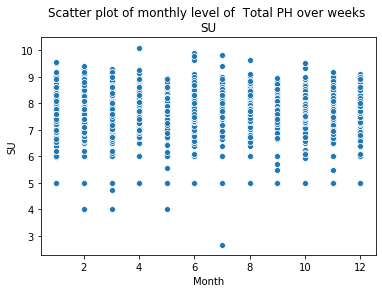

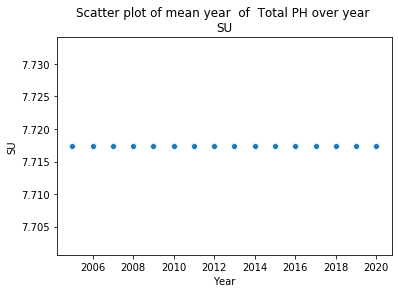

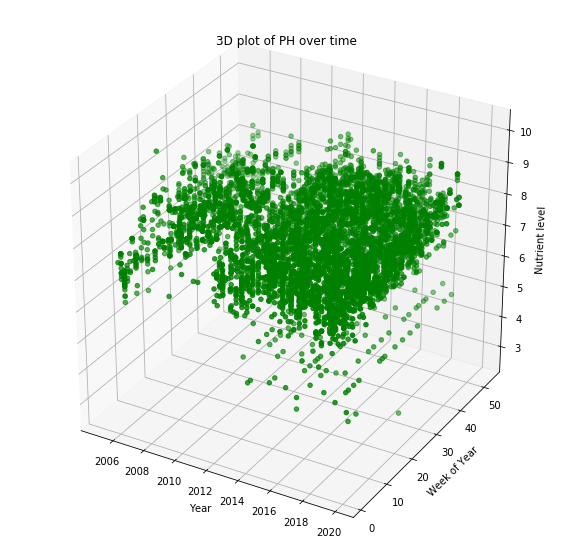

In [13]:

df_cp = pd.DataFrame(point_1_df.copy())
point_1_ph = df_cp[df_cp["Parameter"].str.contains("PH")  ]
### Make the differnt columns     
point_1_ph["Year"] = pd.DatetimeIndex(point_1_ph['Date']).year
point_1_ph["Month"] = pd.DatetimeIndex(point_1_ph['Date']).month
point_1_ph["WeekOfYear"] = pd.DatetimeIndex(point_1_ph['Date']).weekofyear
    
makeDistPlot(point_1_ph, "Distrubtion of PH ", "SU")
makeScatterPlot(point_1_ph, "Total PH over weeks ", "SU", 'w')
makeScatterPlot(point_1_ph, "Total PH over weeks ", "SU", 'm')
makeScatterPlot(point_1_ph, "Total PH over year ", "SU", 'y')
make3Dfig(point_1_ph, "3D plot of PH over time")
   



#### Now lets plot the total nutrients over time

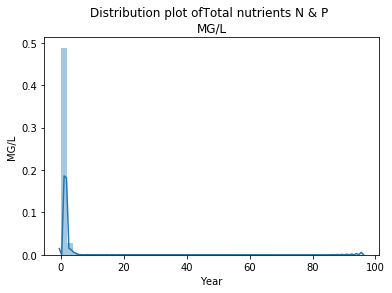

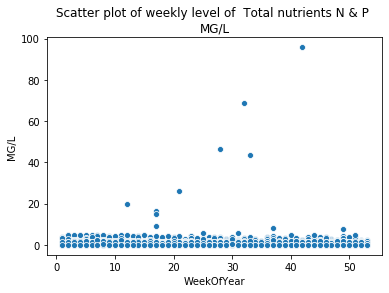

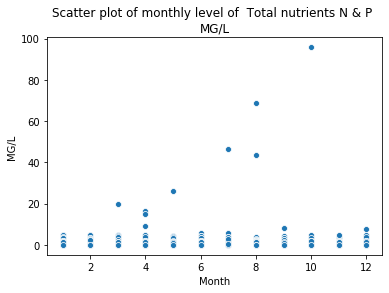

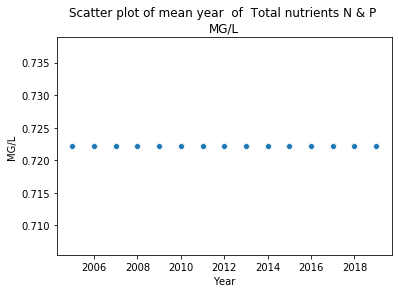

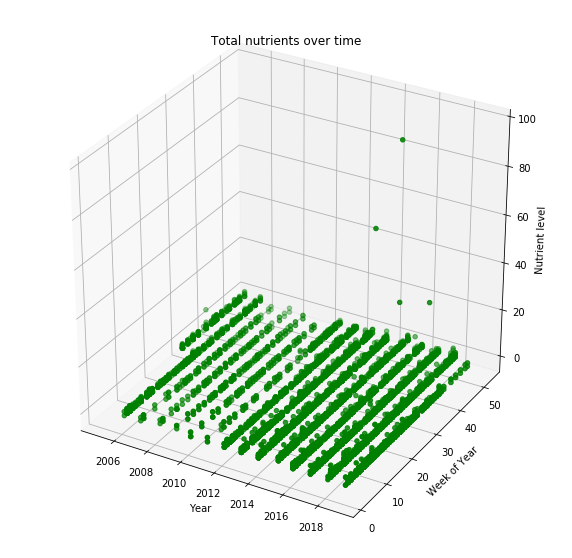

In [14]:
point_1_TP = df_cp[df_cp["Parameter"].str.contains("TP|TN")  ]
### Make the differnt columns     
point_1_TP["Year"] = pd.DatetimeIndex(point_1_TP['Date']).year
point_1_TP["Month"] = pd.DatetimeIndex(point_1_TP['Date']).month
point_1_TP["WeekOfYear"] = pd.DatetimeIndex(point_1_TP['Date']).weekofyear
makeDistPlot(point_1_TP, "Total nutrients N & P ", "MG/L")
makeScatterPlot(point_1_TP, "Total nutrients N & P ", "MG/L", 'w')
makeScatterPlot(point_1_TP, "Total nutrients N & P ", "MG/L", 'm')
makeScatterPlot(point_1_TP, "Total nutrients N & P ", "MG/L", 'y')
make3Dfig(point_1_TP, "Total nutrients over time")

### Now lets look at the outliers for the nutrients and see where they are located

In [15]:
#x =point_1_TP[point_1_TP["MeasureValue" ]>= 10]
x = point_1_TP
tp_mean = x["MeasureValue"].mean()
tp_var = x["MeasureValue"].var()
print(tp_mean, tp_var)
x["MeasureValue"] = (x["MeasureValue"] - tp_mean)/ np.sqrt(tp_var)
outliers_TP = x[x["MeasureValue"] > 2.5 ]

lat_min, lat_max, long_min, long_max = x["Latitude"].min(), x["Latitude"].max(), x["Longitude"].min(), x["Longitude"].max()
print(long_max, long_min,"    ", lat_max, lat_min)

0.7221774516535091 2.8169889399919925
-75.5354 -78.26556      42.2052 39.5478


In [16]:
outliers_TP.shape

(17, 70)

In [19]:
map_outliers_TP = folium.Map(
    location=[40.943, -77.786],
    zoom_start=7,
    tiles="Stamen Toner"
)
for i in range(0,len(outliers_TP)):
    folium.Marker([outliers_TP.iloc[i]['Latitude'], outliers_TP.iloc[i]['Longitude']], popup=outliers_TP.iloc[i]['HUCNAME_']).add_to(map_outliers_TP)

In [20]:
map_outliers_TP